# Pursuit Problem

* Multiple pursuers, single evader.
* The domain is continuous, irregularly shaped (not convex, holes, etc)

What are optimal target points for the pursuers to surround and capture the evader?

Steps
* Subdivide the domain into nodes either (using a grid, voronoi analysis, etc)
* Use Fast Marching Method to find shortest path cells
* Determine lines of control
  * Edges of evader shortest path cell
  * Barriers break up lines of control
* Distribute pursuers along the lines of control


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Create a simple 4x4 grid example domain

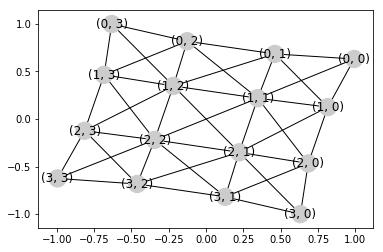

In [2]:
def create4x4grid():
    G = nx.grid_2d_graph(4,4)
    G.add_edge((0,0),(1,1))
    G.add_edge((1,0),(0,1))
    G.add_edge((1,0),(2,1))
    G.add_edge((0,1),(1,2))
    G.add_edge((1,1),(2,2))
    G.add_edge((1,1),(0,2))
    G.add_edge((1,1),(2,0))
    G.add_edge((1,2),(2,1))
    G.add_edge((1,2),(2,3))
    G.add_edge((1,2),(0,3))
    G.add_edge((2,1),(3,2))
    G.add_edge((2,1),(3,0))
    G.add_edge((2,2),(3,3))
    G.add_edge((2,2),(3,1))
    G.add_edge((2,2),(1,3))
    G.add_edge((0,2),(1,3))
    G.add_edge((2,0),(3,1))
    G.add_edge((2,3),(3,2))
    return G
G = create4x4grid()

# layout nodes
pos = nx.spring_layout(G, iterations=100)

nx.draw_networkx(G, pos, node_color=['#CCCCCC']*len(G.nodes()))

# Setup Start Positions

In [3]:
# evader is reddish
evade = '#ff9999'

# pursuers are bluish
pursue1 = '#9999ff'
pursue2 = '#99ddff'
pursue3 = '#ddddff'

#unclaimed is light gray
unclaimed = '#CCCCCC'

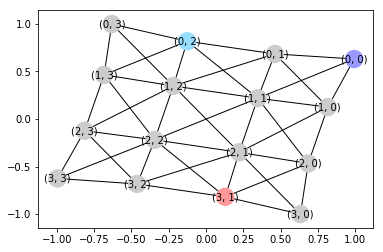

In [4]:
to_visit = []

def reset_graph():
    for node in G.nodes():
        d = G.node[node]
        d['distance'] = 999
        d['spotted'] = False
        d['team'] = unclaimed
        d['reserved'] = False

def add_start(team, pos):
    """set starting position for a color"""
    G.node[pos]['spotted'] = True
    G.node[pos]['team'] = team
    G.node[pos]['distance'] = 0
    
    to_visit.append(pos)

reset_graph()
add_start(pursue1, (0,0))
add_start(pursue2,(0,2))
add_start(evade,(3,1))

colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True)

# Execute Fast March

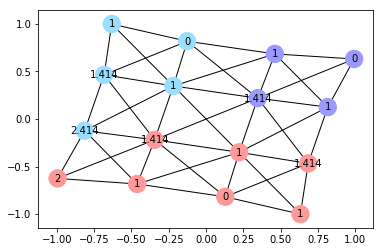

In [5]:

def fast_march():
    global to_visit
    while len(to_visit)>0:
        curr_node = to_visit[0]
        to_visit = to_visit[1:]

        # get all neighbors that haven't been spotted yet
        to_visit += [x for x in G.neighbors(curr_node) if not G.node[x]['spotted']]
        for spot in [x for x in G.neighbors(curr_node) if not G.node[x]['reserved']]:
            # check for shortest path
            G.node[spot]['spotted'] = True
            if (spot[0] != curr_node[0]) and (spot[1] != curr_node[1]):
                ddist = 2**(1/2)
            else:
                ddist = 1
            dist = G.node[curr_node]['distance'] + ddist
            if G.node[spot]['distance'] > dist:
                G.node[spot]['distance'] = dist
                G.node[spot]['team'] = G.node[curr_node]['team']

x = fast_march()
labels = {k:str(G.node[k]['distance'])[:5] for k in G.nodes()}
colors = [G.node[x]['team'] for x in G.nodes]

nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True, labels=labels)

There are two control line segments and two pursuers. The midpoint of one is near (2, 2), the midpoint of the other is near (2, 1). The two pursuers should use those as target destinations.

# Pursuers > Control Line Segments

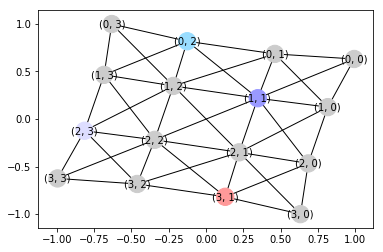

In [6]:
reset_graph()
add_start(pursue1, (1,1))
add_start(pursue2,(0,2))
add_start(pursue3,(2,3))

add_start(evade,(3,1))

colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True)

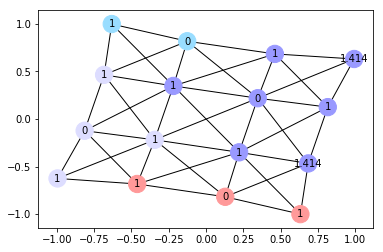

In [7]:
fast_march()
labels = {k:str(G.node[k]['distance'])[:5] for k in G.nodes()}
colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True, labels=labels)

This is getting crowded. Two of the pursuers have control lines, but the third does not. To support his comrades, he can target the vertex between the two midpoints. If there were additional pursuers we could subdivide the control lines.

# Control Line Segments > Pursuers

In [8]:
# create a barrier
G.remove_node((2,2))
G.remove_node((2,1))

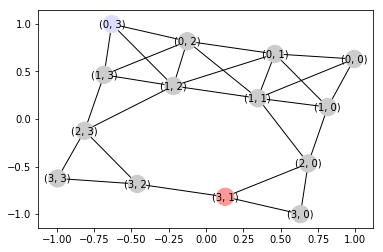

In [9]:
reset_graph()
add_start(pursue3,(0,3))
add_start(evade,(3,1))
colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True)

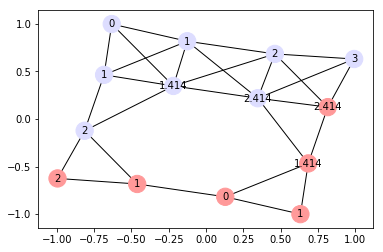

In [10]:
fast_march()
labels = {k:str(G.node[k]['distance'])[:5] for k in G.nodes()}
colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True, labels=labels)

A barrier has broken up the control line into two segments, but there is only one pursuer. Going toward the midpoint of the two segments is a bad idea because the pursuer will end up trying to stay on the opposite side of the barrier. The best strategy is probably to go toward the closest control line. This is basically equivalent to directly chase the evader along the shortest path.

# Pursuit Strategy Summary
* Try to evenly distribute pursuers along the control line
* If there is a barrier on the control line, don't treat it as one line. If the number of pursuers doesn't divide evenly, send the remainder to the closer control line segment.

# Guarding and Runbys
This time, the evader has a goal destination and the pursuers try to prevent the evader from reaching the goal.


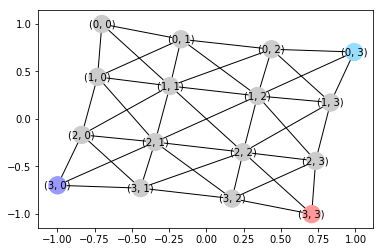

In [13]:
goal = '#ffff00'
G = create4x4grid()
pos = nx.spring_layout(G, iterations=100)
reset_graph()
add_start(pursue1,(3,0))
add_start(pursue2, (0,3))
add_start(evade,(3,3))
#add_start(goal, (0,3))


colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True)

The pursuers objective is to get in between the enemy and the goal. The enemies objective is to reach the goal while avoiding the pursuers. 

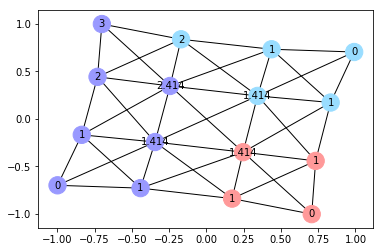

In [14]:
fast_march()
labels = {k:str(G.node[k]['distance'])[:5] for k in G.nodes()}
colors = [G.node[x]['team'] for x in G.nodes]
nx.draw_networkx(G, pos, font_size=10, node_color=colors, with_labels=True, labels=labels)